Part A: Implement Perceptron

In [ ]:
#%load_ext autoreload
#%autoreload 2
#from perceptron import Perceptron, PerceptronOptimizer

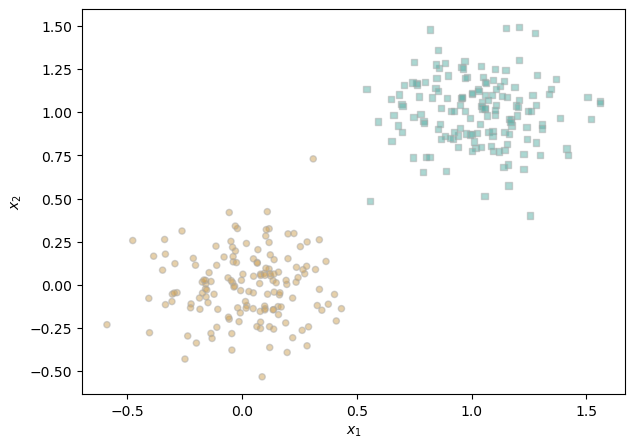

In [115]:

import torch
import matplotlib.pyplot as plt

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,2))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

In [105]:
# Three Classes

class LinearModel:

    def __init__(self):
        self.w = None 

    def score(self, X):
        """
        Compute the scores for each data point in the feature matrix X. 
        The formula for the ith entry of s is s[i] = <self.w, x[i]>. 

        If self.w currently has value None, then it is necessary to first initialize self.w to a random value. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            s torch.Tensor: vector of scores. s.size() = (n,)
        """
        if self.w is None: 
            self.w = torch.rand((X.size()[1]))

        s = X@self.w
        return s
        

    def predict(self, X):
        """
        Compute the predictions for each data point in the feature matrix X. The prediction for the ith data point is either 0 or 1. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            y_hat, torch.Tensor: vector predictions in {0.0, 1.0}. y_hat.size() = (n,)
        """
        scores = self.score(X)
        y_hat = (scores >= 0.5).float()
        return y_hat

class Perceptron(LinearModel):

    def loss(self, X, y):

        
        """
            Compute the misclassification rate. A point i is classified correctly if it holds that s_i*y_i_ > 0, where y_i_ is the *modified label* that has values in {-1, 1} (rather than {0, 1}). 

            ARGUMENTS: 
                X, torch.Tensor: the feature matrix. X.size() == (n, p), 
                where n is the number of data points and p is the 
                number of features. This implementation always assumes 
                that the final column of X is a constant column of 1s. 

                y, torch.Tensor: the target vector.  y.size() = (n,). The possible labels for y are {0, 1}
            
            HINT: In order to use the math formulas in the lecture, you are going to need to construct a 
            modified set of targets and predictions that have entries in {-1, 1} -- 
            otherwise none of the formulas will work right! An easy to to make this conversion is: 
            
            y_ = 2*y - 1
        """   
        scores = self.score(X)
        y_ = 2*y-1
        return (1.0 *(scores * y_ <= 0)).mean()
    

    def grad(self, X, y):
        
        score = self.score(X)
        y_ = 2*y-1
        misclassified = (score * y_) < 0
        #return misclassified * y_ * X
        #print("Misclassified: ", misclassified.size())
        #print("X: ",X.size())
        return (misclassified * (X * y_))

class PerceptronOptimizer:

    def __init__(self, model):
        self.model = model 
    
    def step(self, X, y):
        """
        Compute one step of the perceptron update using the feature matrix X 
        and target vector y. 
        """
        
        y_ = 2*y - 1
        s = self.model.loss(X,y)
        #print("W size: ", self.model.w.size())
        self.model.w += self.model.grad(X, y).squeeze()

        
    


GRAPHING LOSS FUNCTION OVER TIME

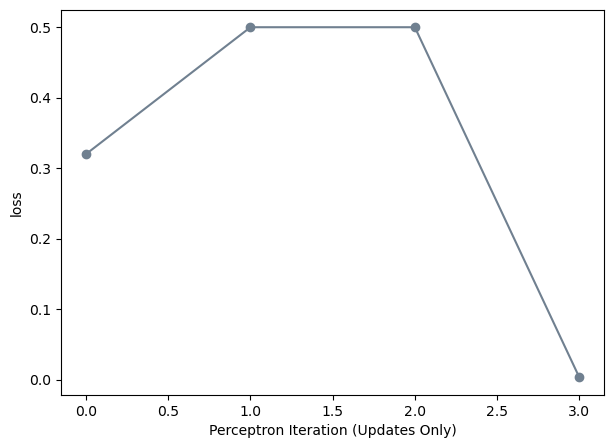

In [116]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

max_iterations = 100
iterations = 0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

loss_threshold = 0.01

#while loss > 0: # dangerous -- only terminates if data is linearly separable
while iterations < max_iterations:
    # not part of the update: just for tracking our progress 

    if (loss < loss_threshold):
        break

    loss = p.loss(X, y) 
    loss_vec.append(loss)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
                
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iterations += 1
                  


plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

VISUALIZING PERCEPTRON ALGORITHM OVER SEVERAL ITERATIONS

RuntimeError: The size of tensor a (3) must match the size of tensor b (300) at non-singleton dimension 1

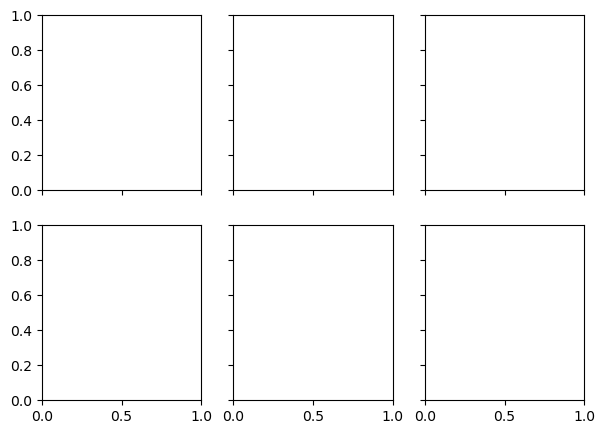

In [117]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []



while loss > 0:

    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i, local_loss = opt.step(X, y)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()